<a href="https://colab.research.google.com/github/NicoRota-0/BIS-project/blob/main/BIS_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pm4py

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import pm4py
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import pareto
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.filtering.log.timestamp import timestamp_filter
from pm4py.algo.filtering.log.start_activities import start_activities_filter
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.algo.discovery.temporal_profile import algorithm as temporal_profile_discovery

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.batches import algorithm 

# visual
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.objects.conversion.process_tree import converter as pt_converter

# eval
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

In [4]:
PATH = 'drive/MyDrive/BIS_files/'

In [5]:
def load_filter_log(file_name, date1 = "2018-01-01 00:00:00", date2 = "2019-12-31 23:59:59"):
  """This function loads and filter a log from a xes file,
  the filter eliminates all the cases with events outside the interval
  defined by the two timestamp in input.
  """
  tmp_log = xes_importer.apply(PATH + file_name + '.xes')

  activities_all = attributes_filter.get_attribute_values(tmp_log, "id")
  list_activities_id_all = len(list(activities_all))

  # filtering all the events happened/started in 2017
  filtered_log = timestamp_filter.filter_traces_contained(tmp_log, date1, date2)

  # filtering events < 2 and > 100
  filtered_log = pm4py.filter_case_size(filtered_log, 2, 100)

  # filtering events < 24h and > 1000 days
  filtered_log = pm4py.filter_case_performance(filtered_log, 86400, 1000*86400)

  activities_all = attributes_filter.get_attribute_values(filtered_log, "id")
  
  list_activities_id_filt = len(list(activities_all))

  print(file_name + ' Data Before filtering:', str(list_activities_id_all), 'Events;', str(len(tmp_log)), 'Cases.')
  print(file_name + ' Data After filtering:', str(list_activities_id_filt), 'Events;', str(len(filtered_log)), 'Cases.')
  
  return filtered_log

In [6]:
def compute_duration_statistics(log):
  all_case_durations = pm4py.get_all_case_durations(log)
  mean = np.mean(all_case_durations)
  std = np.std(all_case_durations)
  median = np.median(all_case_durations)
  min = np.min(all_case_durations)
  max = np.max(all_case_durations)
  print("Mean:", mean/86400.0, "Standard deviation:", std/86400.0, 
        "Median:", median/86400.0, "Min:", min/86400.0, "Max:", max/86400.0)
  """
  data_log = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
  profile = data_log.groupby('case:concept:name').agg(
  Activity = ('concept:name', 'count'),\
  Activity_list = ('concept:name', lambda x: ','.join(x) ),\
  Rosource = ('org:resource', 'nunique'),\
  Duration = ('time:timestamp', lambda x: x.max()- x.min()),\
  )
  mean_duration = profile[(profile['Duration'] > '0:0:0')].agg('max')
  """
  return all_case_durations

def duration_boxplot(all_case_durations, log_name):
  lis = np.divide(all_case_durations, 86400.0)
  fig = plt.figure(figsize = (15, 5))
  plt.title('Box-Plot ' + log_name)
  red_square = dict(markerfacecolor='r', marker='s')
  plt.boxplot(lis, flierprops=red_square, vert=False, autorange = True)

def variant_analysis(log, log_name):
  # Count the cases per variant 
  variants_count = case_statistics.get_variant_statistics(log)
  variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)

  print('Number of variants:', len(variants_count))
  variants_df = pd.DataFrame.from_records(variants_count)

  # Prepare the dimensions to plot
  # Put variants and counts into lists of prefered length
  variant = variants_df[0:100].index
  frequency = variants_df[0:100]['count']

  # return a list of log values from a list 
  frequency_log = [math.log(i, 2) for i in frequency] 

  # Plot the histogram of the frequencies
  fig = plt.figure(figsize = (15, 5))

  # creating the bar plot
  plt.bar(variant, frequency, color ='orange',
          width = 0.4)
  plt.xlabel("variants sorted by frequency")
  plt.ylabel("frequency")
  plt.title("bar chart of variants frequency for " + log_name)
  return variants_df

def variant_cdf_pdf(variants_df):
  data= variants_df[1:100]['count']
  # getting data of the histogram
  count, bins_count = np.histogram(data, bins=100)

  # finding the PDF of the histogram using count values
  pdf = count / sum(count)
    
  # using numpy np.cumsum to calculate the CDF
  # We can also find using the PDF values by looping and adding
  cdf = np.cumsum(pdf)
    
  # plotting PDF (probability density function) and CDF (cumulative densitive function)
  plt.plot(bins_count[1:], pdf, color="red", label="PDF")
  plt.plot(bins_count[1:], cdf, label="CDF")
  plt.legend()

**Loading and Filtering Events that started in 2017**

In [7]:
domesticDeclarations = load_filter_log('DomesticDeclarations')
internationalDeclarations = load_filter_log('InternationalDeclarations')
permitLog = load_filter_log('PermitLog')
prepaidTravelCost = load_filter_log('PrepaidTravelCost')
requestForPayment = load_filter_log('RequestForPayment')
logs = {"DomesticDeclarations": domesticDeclarations, "InternationalDeclarations": internationalDeclarations, 
       "PermitLog": permitLog, "PrepaidTravelCost": prepaidTravelCost, "RequestForPayment": requestForPayment}

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

DomesticDeclarations Data Before filtering: 56437 Events; 10500 Cases.
DomesticDeclarations Data After filtering: 45966 Events; 8061 Cases.


parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

InternationalDeclarations Data Before filtering: 69073 Events; 6449 Cases.
InternationalDeclarations Data After filtering: 55576 Events; 4951 Cases.


parsing log, completed traces ::   0%|          | 0/7065 [00:00<?, ?it/s]

PermitLog Data Before filtering: 86581 Events; 7065 Cases.
PermitLog Data After filtering: 71053 Events; 5594 Cases.


parsing log, completed traces ::   0%|          | 0/2099 [00:00<?, ?it/s]

PrepaidTravelCost Data Before filtering: 16205 Events; 2099 Cases.
PrepaidTravelCost Data After filtering: 13975 Events; 1758 Cases.


parsing log, completed traces ::   0%|          | 0/6886 [00:00<?, ?it/s]

RequestForPayment Data Before filtering: 36796 Events; 6886 Cases.
RequestForPayment Data After filtering: 31261 Events; 5559 Cases.


Log Analisys

Duration statistics for  DomesticDeclarations log
Mean: 11.84151911983625 Standard deviation: 16.03043450092344 Median: 8.033310185185185 Min: 1.0074305555555556 Max: 469.23631944444446
Duration statistics for  InternationalDeclarations log
Mean: 76.22178016085415 Standard deviation: 56.68729848450383 Median: 63.817696759259256 Min: 6.729988425925926 Max: 463.05258101851854
Duration statistics for  PermitLog log
Mean: 83.86629611008487 Standard deviation: 57.38138325766784 Median: 71.11126736111112 Min: 1.4583101851851852 Max: 463.05258101851854
Duration statistics for  PrepaidTravelCost log
Mean: 36.97668368542747 Standard deviation: 39.53091754257682 Median: 24.13574074074074 Min: 1.0327777777777778 Max: 324.97599537037036
Duration statistics for  RequestForPayment log
Mean: 12.830910591683157 Standard deviation: 16.855439360112513 Median: 9.149016203703704 Min: 1.0163888888888888 Max: 405.99306712962965


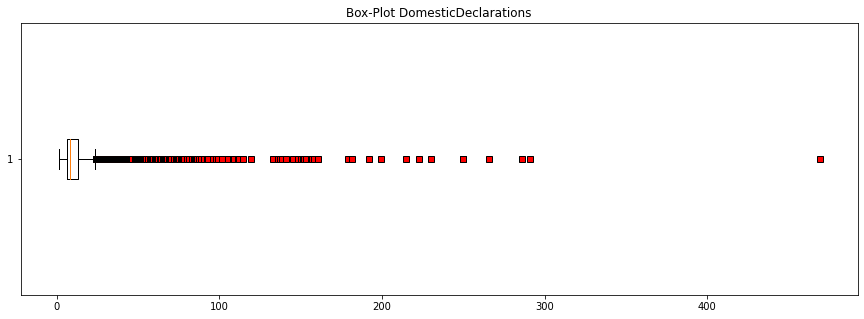

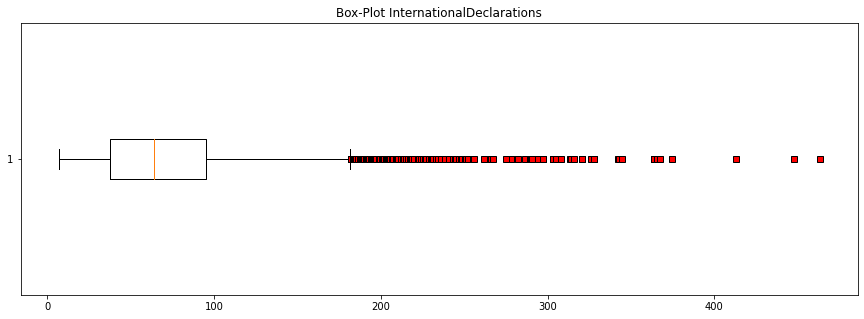

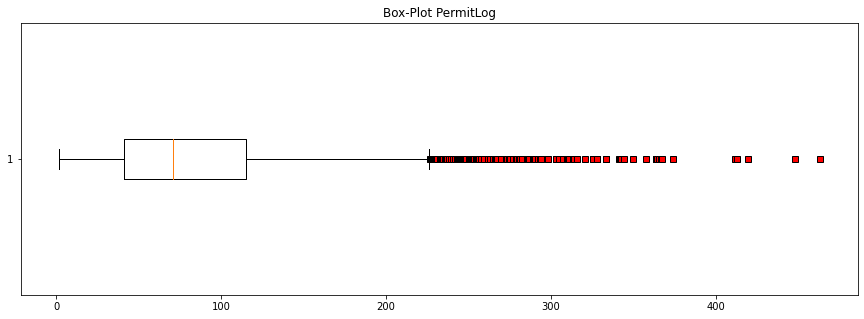

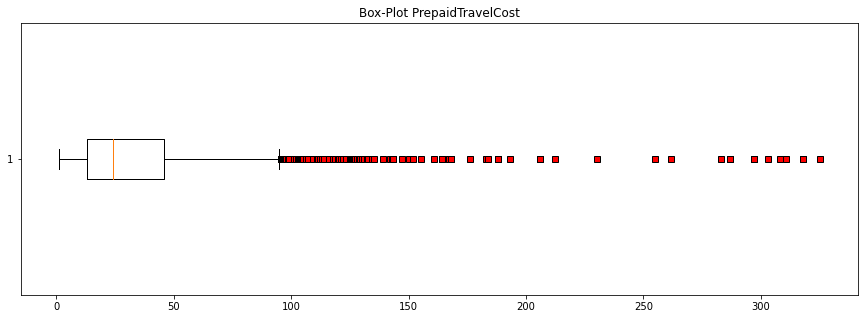

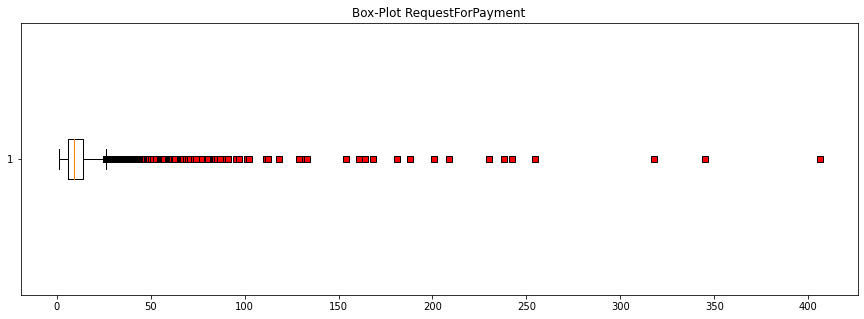

In [8]:
for k in logs:
  print("Duration statistics for ", k, "log")
  log = logs[k]
  all_case_duration = compute_duration_statistics(log)
  duration_boxplot(all_case_duration, k)

Distribution of the events for  DomesticDeclarations log


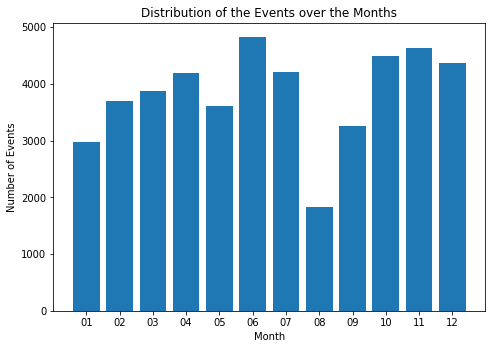

Distribution of the events for  InternationalDeclarations log


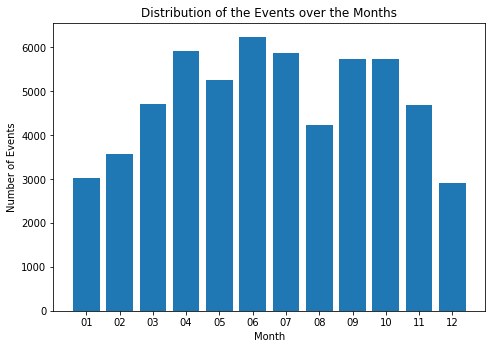

Distribution of the events for  PermitLog log


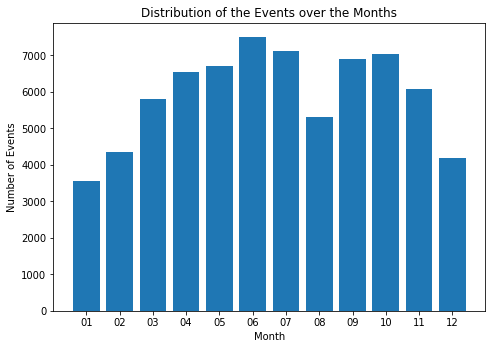

Distribution of the events for  PrepaidTravelCost log


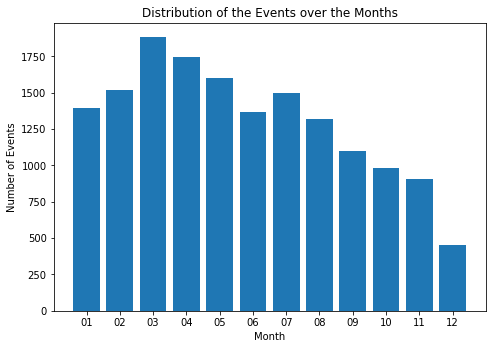

Distribution of the events for  RequestForPayment log


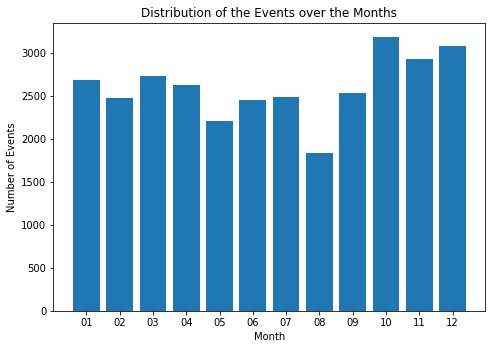

In [9]:
for k in logs:
  print("Distribution of the events for ", k, "log")
  log = logs[k]
  pm4py.view_events_distribution_graph(log, distr_type="months")

Variant analisys for  DomesticDeclarations log
Number of variants: 61
cases handeled: 7903, ratio: 0.9803994541620147, cases rejected: 973 ratio: 0.12070462721746682
cases resubmitted: 976, ratio: 0.12107678948021337, cases with double payments: 0
cases never approved: 102, ratio: 0.012653516933382954
Variant analisys for  InternationalDeclarations log
Number of variants: 522
cases handeled: 4740, ratio: 0.957382347000606, cases rejected: 1457 ratio: 0.29428398303373055
cases resubmitted: 6306, ratio: 1.2736820844273884, cases with double payments: 0
cases never approved: 15, ratio: 0.0030296909715209048
Variant analisys for  PermitLog log
Number of variants: 1114
cases handeled: 4466, ratio: 0.7983553807651055, cases rejected: 1567 ratio: 0.2801215588130139
cases resubmitted: 7979, ratio: 1.4263496603503754, cases with double payments: 1017
cases never approved: 48, ratio: 0.008580622095101895
Variant analisys for  PrepaidTravelCost log
Number of variants: 148
cases handeled: 1687, ra

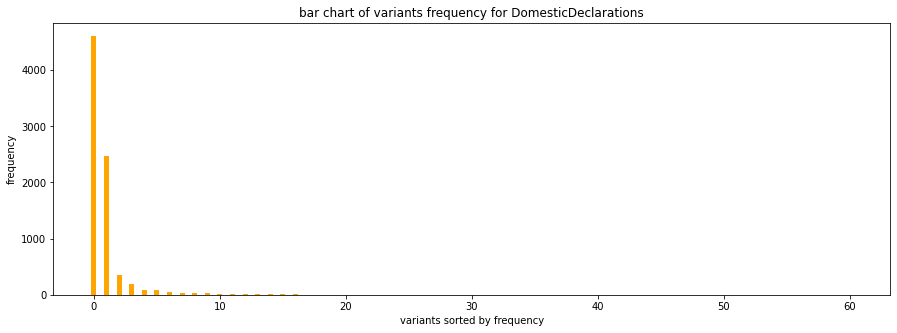

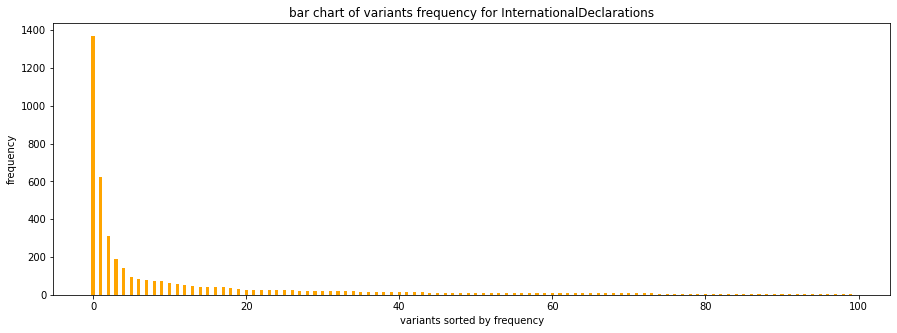

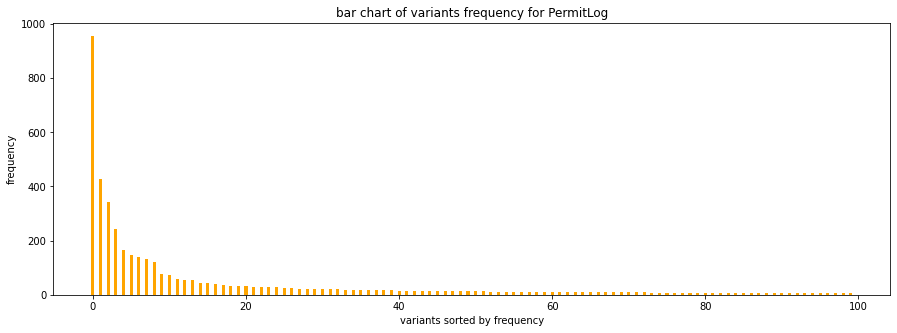

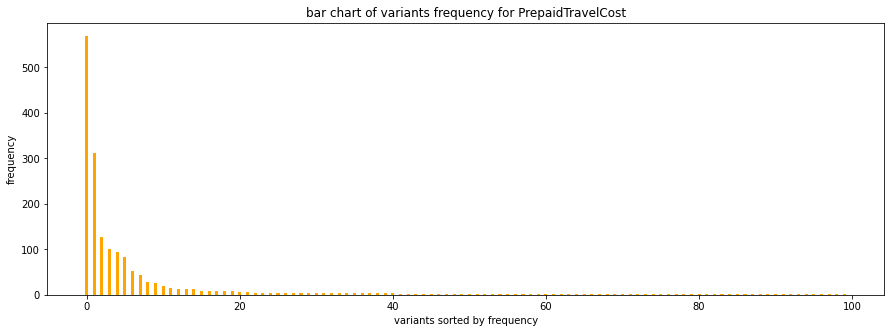

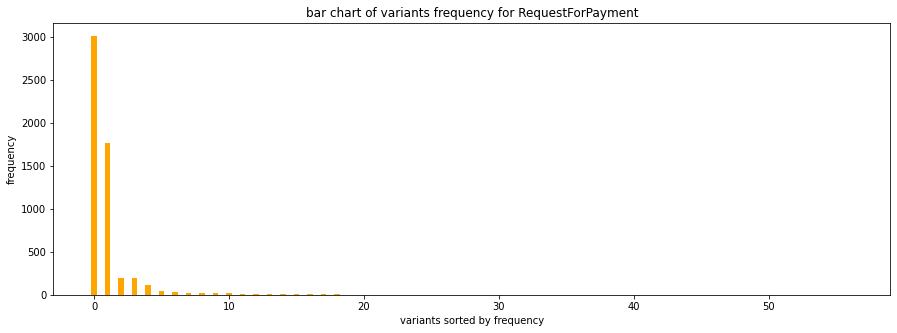

In [10]:
for k in logs:
  print("Variant analisys for ", k, "log")
  log = logs[k]
  variant_df = variant_analysis(log, k)
  variants_count = case_statistics.get_variant_statistics(log)
  number_cases = len(log)
  rejected = 0
  resubmitted = 0
  handled = 0
  never_approved = 0
  double_payments = 0
  for variant in variants_count:
    if "Handled" in variant['variant']:
      handled += variant['count']
    if "APPROVED" not in variant['variant']:
      never_approved += variant['count']
    if "REJECTED" in variant['variant']:
      rejected += variant['count']
    if variant['variant'].count('SUBMITTED') > 1: 
      resubmitted += variant['count'] * (variant['variant'].count('SUBMITTED') - 1)
    if variant['variant'].count('Payment Handled') > 1:
      double_payments += variant['count']
  print(f'cases handeled: {handled}, ratio: {handled/number_cases}, cases rejected: {rejected} ratio: {rejected/number_cases}')
  print(f'cases resubmitted: {resubmitted}, ratio: {resubmitted/number_cases}, cases with double payments: {double_payments}')
  print(f'cases never approved: {never_approved}, ratio: {never_approved / number_cases}')


**Process Discovery**

In [11]:
def net_evaluation(event_log, net, im, fm):
  fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
  prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
  gen = generalization_evaluator.apply(event_log, net, im, fm)
  simp = simplicity_evaluator.apply(net)
  print('Fitness: ', fitness, 'Precision: ', prec, 'Generalization: ', gen, 'Simplicity: ', simp)
  return [fitness['average_trace_fitness'], prec, gen, simp]

In [12]:
def discovery_visualize_evaluate(event_log, visualize=True, result_summary=True):
  activities = pm4py.get_event_attribute_values(log, "concept:name")
  n_activities = len(activities)
  print("-----------------------------------------------")
  print("-------------------Dfg visualization-----------")
  if visualize:
    # Create graph from log
    dfg = dfg_discovery.apply(event_log)
    # Visualise
    parameters = {dfg_visualization.Variants.FREQUENCY.value.Parameters.MAX_NO_EDGES_IN_DIAGRAM: n_activities + int(n_activities)
                  }
    gviz = dfg_visualization.apply(dfg, log=event_log, variant=dfg_visualization.Variants.FREQUENCY, 
                                   parameters = parameters)
    dfg_visualization.view(gviz)

  print("-----------------------------------------------")
  print("-------------------Alpha Miner-----------------")
  # Discover a Petri Net using Alpha Miner
  net, im, fm = alpha_miner.apply(event_log)
  if visualize:
  # Visualise 
    gviz = pn_visualizer.apply(net, im, fm, variant=pn_visualizer.Variants.FREQUENCY, log=event_log)
    pn_visualizer.view(gviz)
  # Evaluate
  alpha_res = net_evaluation(event_log, net, im, fm)

  print("-----------------------------------------------")
  print("-------------------Heuristic Miner-------------")
  # Discover a Petri Net using Heuristic Miner
  parameters = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.98,
                heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT: 5, 
                heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES: 5,
                heuristics_miner.Variants.CLASSIC.value.Parameters.DFG_PRE_CLEANING_NOISE_THRESH: 0.1} 
  net, im, fm = heuristics_miner.apply(event_log, parameters=parameters)
  if visualize:
    # Visualise a Petri Net
    gviz = pn_visualizer.apply(net, im, fm, log=event_log, variant=pn_visualizer.Variants.PERFORMANCE)
    pn_visualizer.view(gviz)
  # Evaluate
  heu_res = net_evaluation(event_log, net, im, fm)

  h_net = net
  h_im = im
  h_fm = fm

  net = heuristics_miner.apply_heu(event_log, parameters=parameters)
  gviz = hn_visualizer.apply(net)
  hn_visualizer.view(gviz)


  print("-----------------------------------------------")
  print("-------------------Inductive Miner-------------")
  # Discover process tree using Inductive Miner Infrequent
  # Produces a more precise model, without fitness guarantees, by eliminating some behavior.
  tree = inductive_miner.apply_tree(event_log)
  from pm4py.visualization.process_tree import visualizer as pt_visualizer
  gviz = pt_visualizer.apply(tree, parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
  pt_visualizer.view(gviz)
  # Convert process tree into a Petri Net
  net, im, fm = pt_converter.apply(tree)
  if visualize:
  ## Visualise
    gviz = pn_visualizer.apply(net, im, fm, 
                              variant=pn_visualizer.Variants.FREQUENCY, 
                              log=event_log)
    pn_visualizer.view(gviz)
  # Evaluate
  indu_res = net_evaluation(event_log, net, im, fm)

  #RESULTS
  if result_summary:
    from tabulate import tabulate
    alpha_res.insert(0, 'Alpha')
    heu_res.insert(0, 'Heuristic')
    indu_res.insert(0, 'Inductive')
    print(tabulate([alpha_res, heu_res, indu_res], headers=['Miner', 'Fitness', 'Precision', 'Generalization', 'Simplicity'], tablefmt='orgtbl'))

  return h_net, h_im, h_fm

-----------------------------------------------
-------------------Dfg visualization-----------
-----------------------------------------------
-------------------Alpha Miner-----------------


replaying log with TBR, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/214 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.8496277346463348, 'log_fitness': 0.8457784798203213, 'percentage_of_fitting_traces': 0.0} Precision:  0.0 Generalization:  0.8783002677681807 Simplicity:  0.5789473684210527
-----------------------------------------------
-------------------Heuristic Miner-------------


replaying log with TBR, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/214 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 99.33010792705619, 'average_trace_fitness': 0.9994090125938941, 'log_fitness': 0.9991204925241864, 'percentage_of_fitting_traces': 99.33010792705619} Precision:  0.9972184643394485 Generalization:  0.9146210833993865 Simplicity:  0.7142857142857143


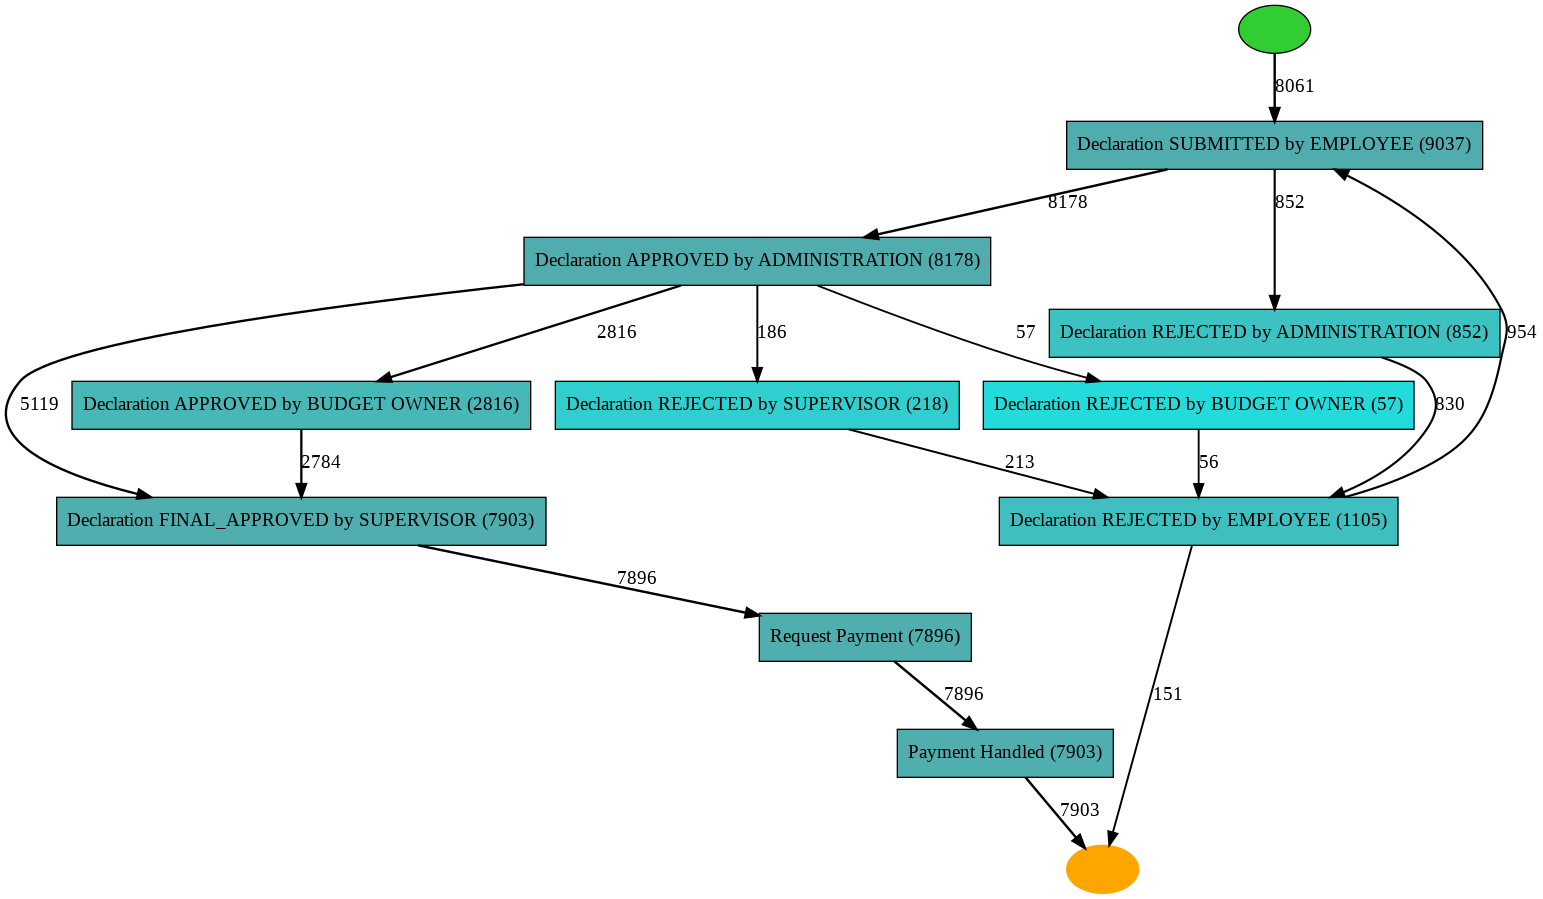

-----------------------------------------------
-------------------Inductive Miner-------------


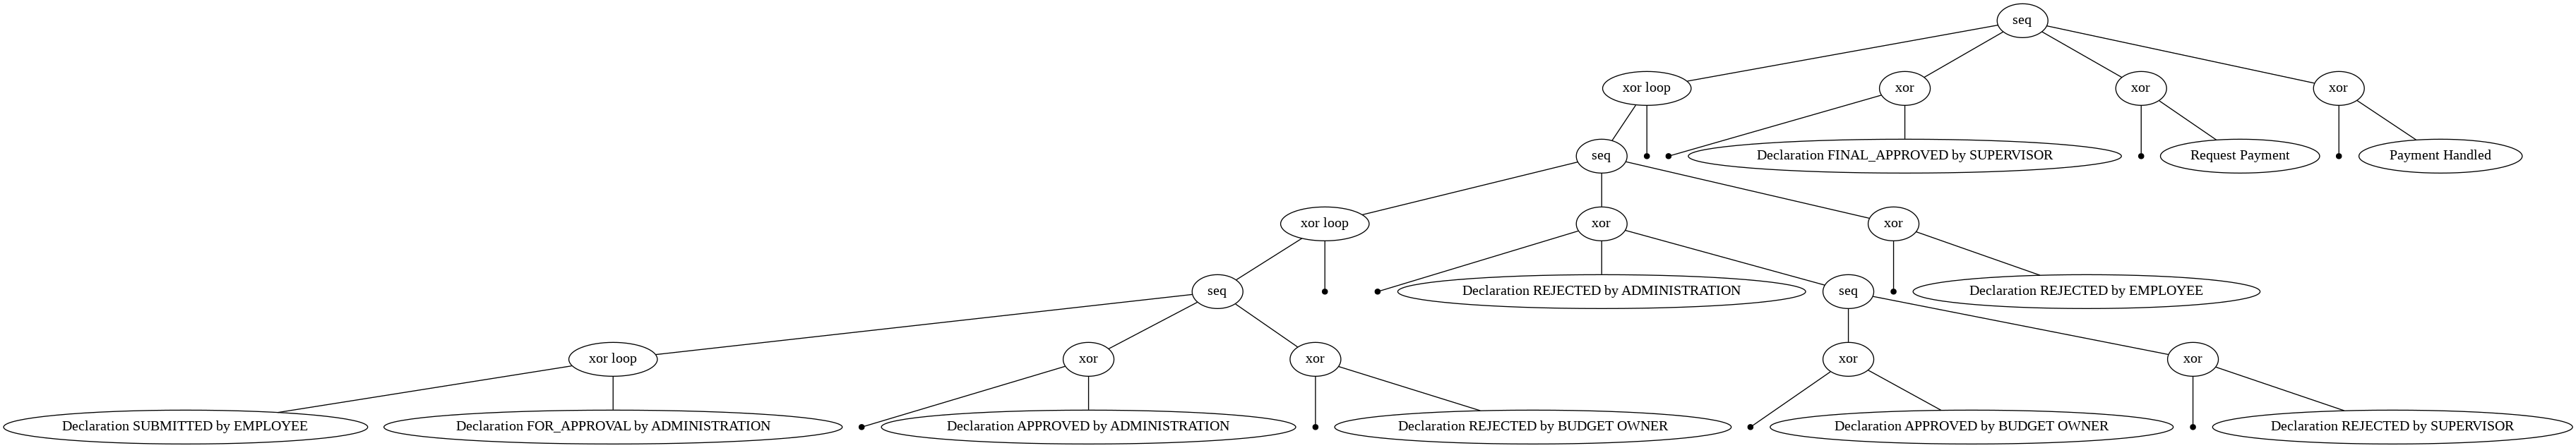

replaying log with TBR, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/214 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0} Precision:  0.38923963053931576 Generalization:  0.8987804158888294 Simplicity:  0.6470588235294118
| Miner     |   Fitness |   Precision |   Generalization |   Simplicity |
|-----------+-----------+-------------+------------------+--------------|
| Alpha     |  0.849628 |    0        |         0.8783   |     0.578947 |
| Heuristic |  0.999409 |    0.997218 |         0.914621 |     0.714286 |
| Inductive |  1        |    0.38924  |         0.89878  |     0.647059 |


In [13]:
dom_net, dom_im, dom_fm = discovery_visualize_evaluate(domesticDeclarations, visualize = False)

-----------------------------------------------
-------------------Dfg visualization-----------
-----------------------------------------------
-------------------Alpha Miner-----------------


replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2852 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.6762500958077613, 'log_fitness': 0.6807790588305668, 'percentage_of_fitting_traces': 0.0} Precision:  0.0 Generalization:  0.846257201709615 Simplicity:  0.41732283464566927
-----------------------------------------------
-------------------Heuristic Miner-------------


replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2852 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 62.53282165219148, 'average_trace_fitness': 0.9771845897256198, 'log_fitness': 0.9787859433198698, 'percentage_of_fitting_traces': 62.53282165219148} Precision:  0.656575338195873 Generalization:  0.8906449006534387 Simplicity:  0.6545454545454545


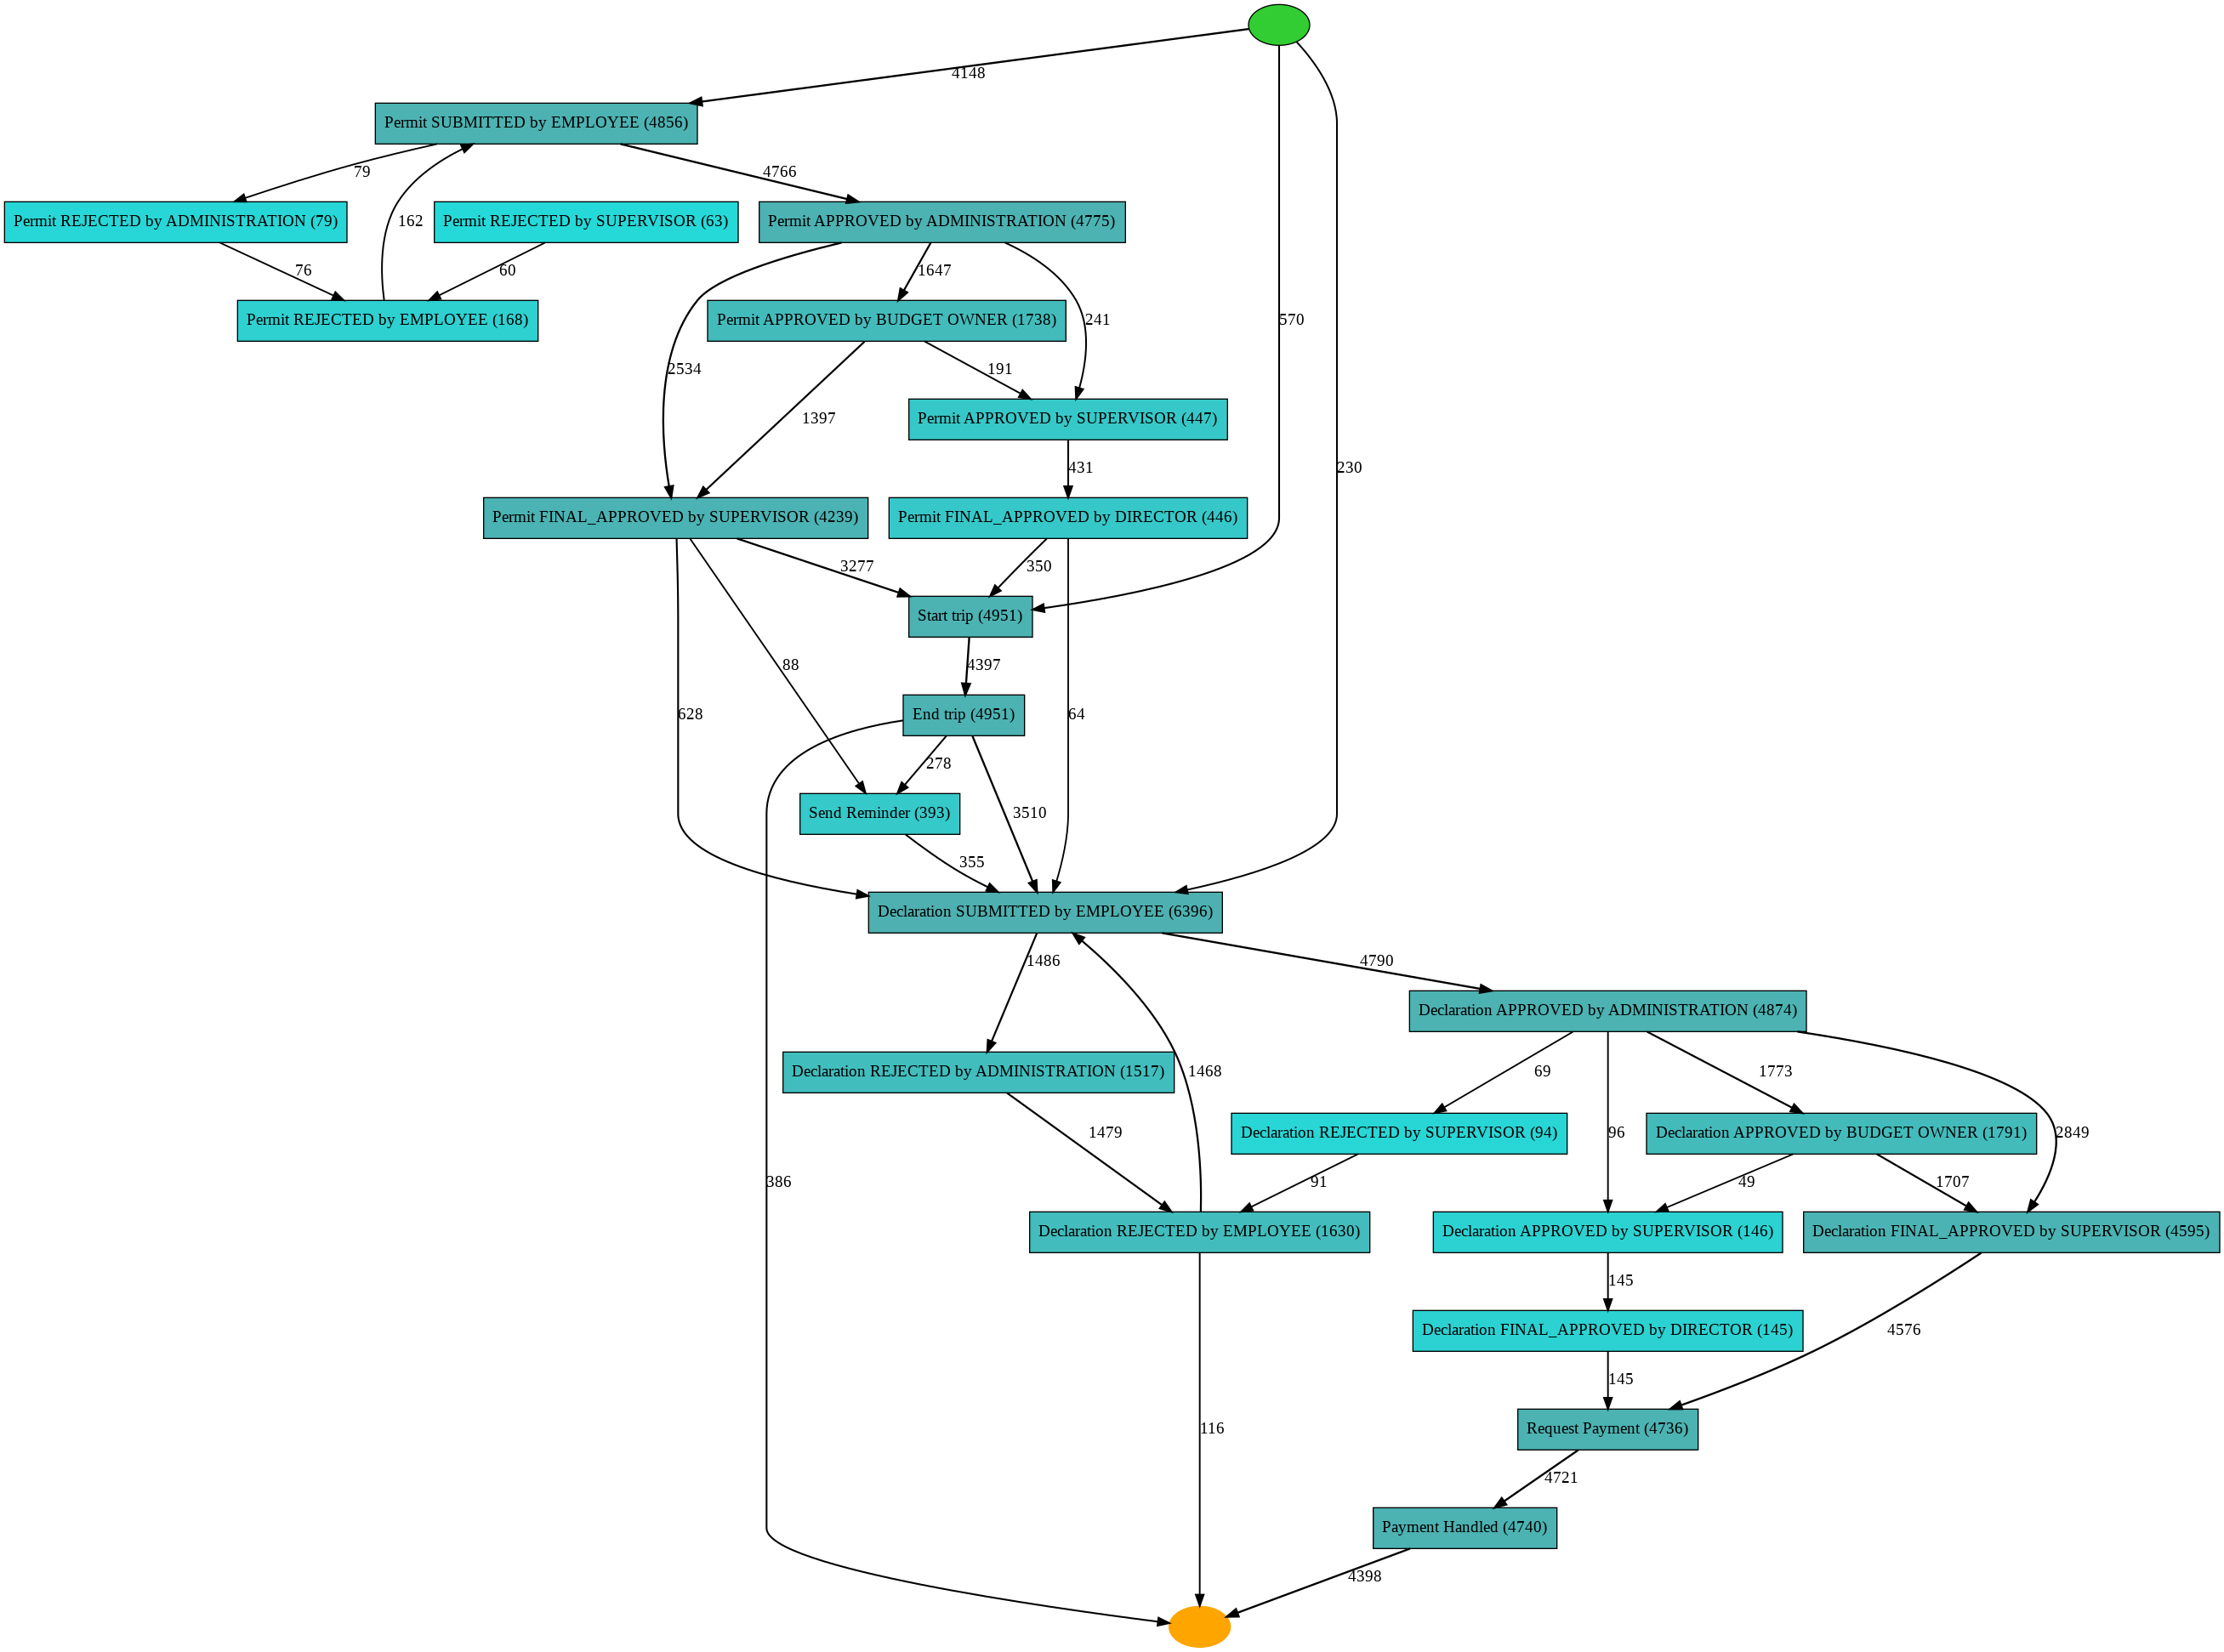

-----------------------------------------------
-------------------Inductive Miner-------------


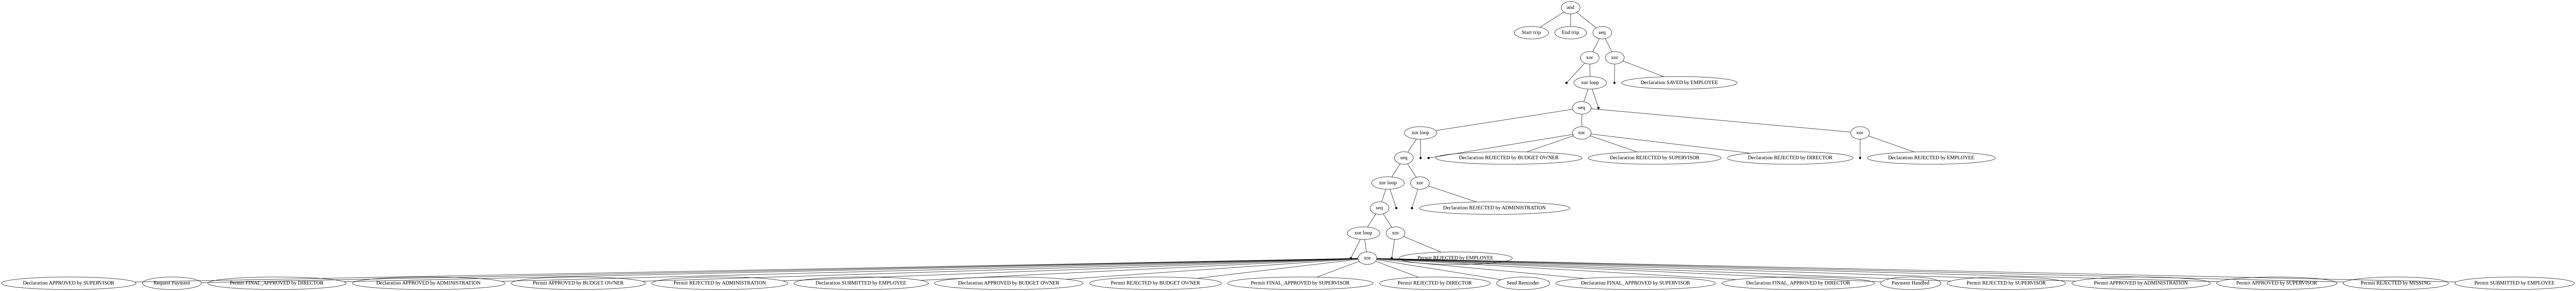

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2852 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0} Precision:  0.09997653759447034 Generalization:  0.8914812790824339 Simplicity:  0.5294117647058824
| Miner     |   Fitness |   Precision |   Generalization |   Simplicity |
|-----------+-----------+-------------+------------------+--------------|
| Alpha     |  0.67625  |   0         |         0.846257 |     0.417323 |
| Heuristic |  0.977185 |   0.656575  |         0.890645 |     0.654545 |
| Inductive |  1        |   0.0999765 |         0.891481 |     0.529412 |


In [14]:
int_net, int_im, int_fm = discovery_visualize_evaluate(internationalDeclarations, visualize = False)

-----------------------------------------------
-------------------Dfg visualization-----------
-----------------------------------------------
-------------------Alpha Miner-----------------


replaying log with TBR, completed variants ::   0%|          | 0/1114 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9861 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1114 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.44587009106818504, 'log_fitness': 0.4473013019646345, 'percentage_of_fitting_traces': 0.0} Precision:  0.0 Generalization:  0.8266578573174985 Simplicity:  0.5855855855855855
-----------------------------------------------
-------------------Heuristic Miner-------------


replaying log with TBR, completed variants ::   0%|          | 0/1114 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9861 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1114 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 53.235609581694675, 'average_trace_fitness': 0.9651531315472709, 'log_fitness': 0.9593866506951327, 'percentage_of_fitting_traces': 53.235609581694675} Precision:  0.9216437867712605 Generalization:  0.9094556537055458 Simplicity:  0.6209150326797385


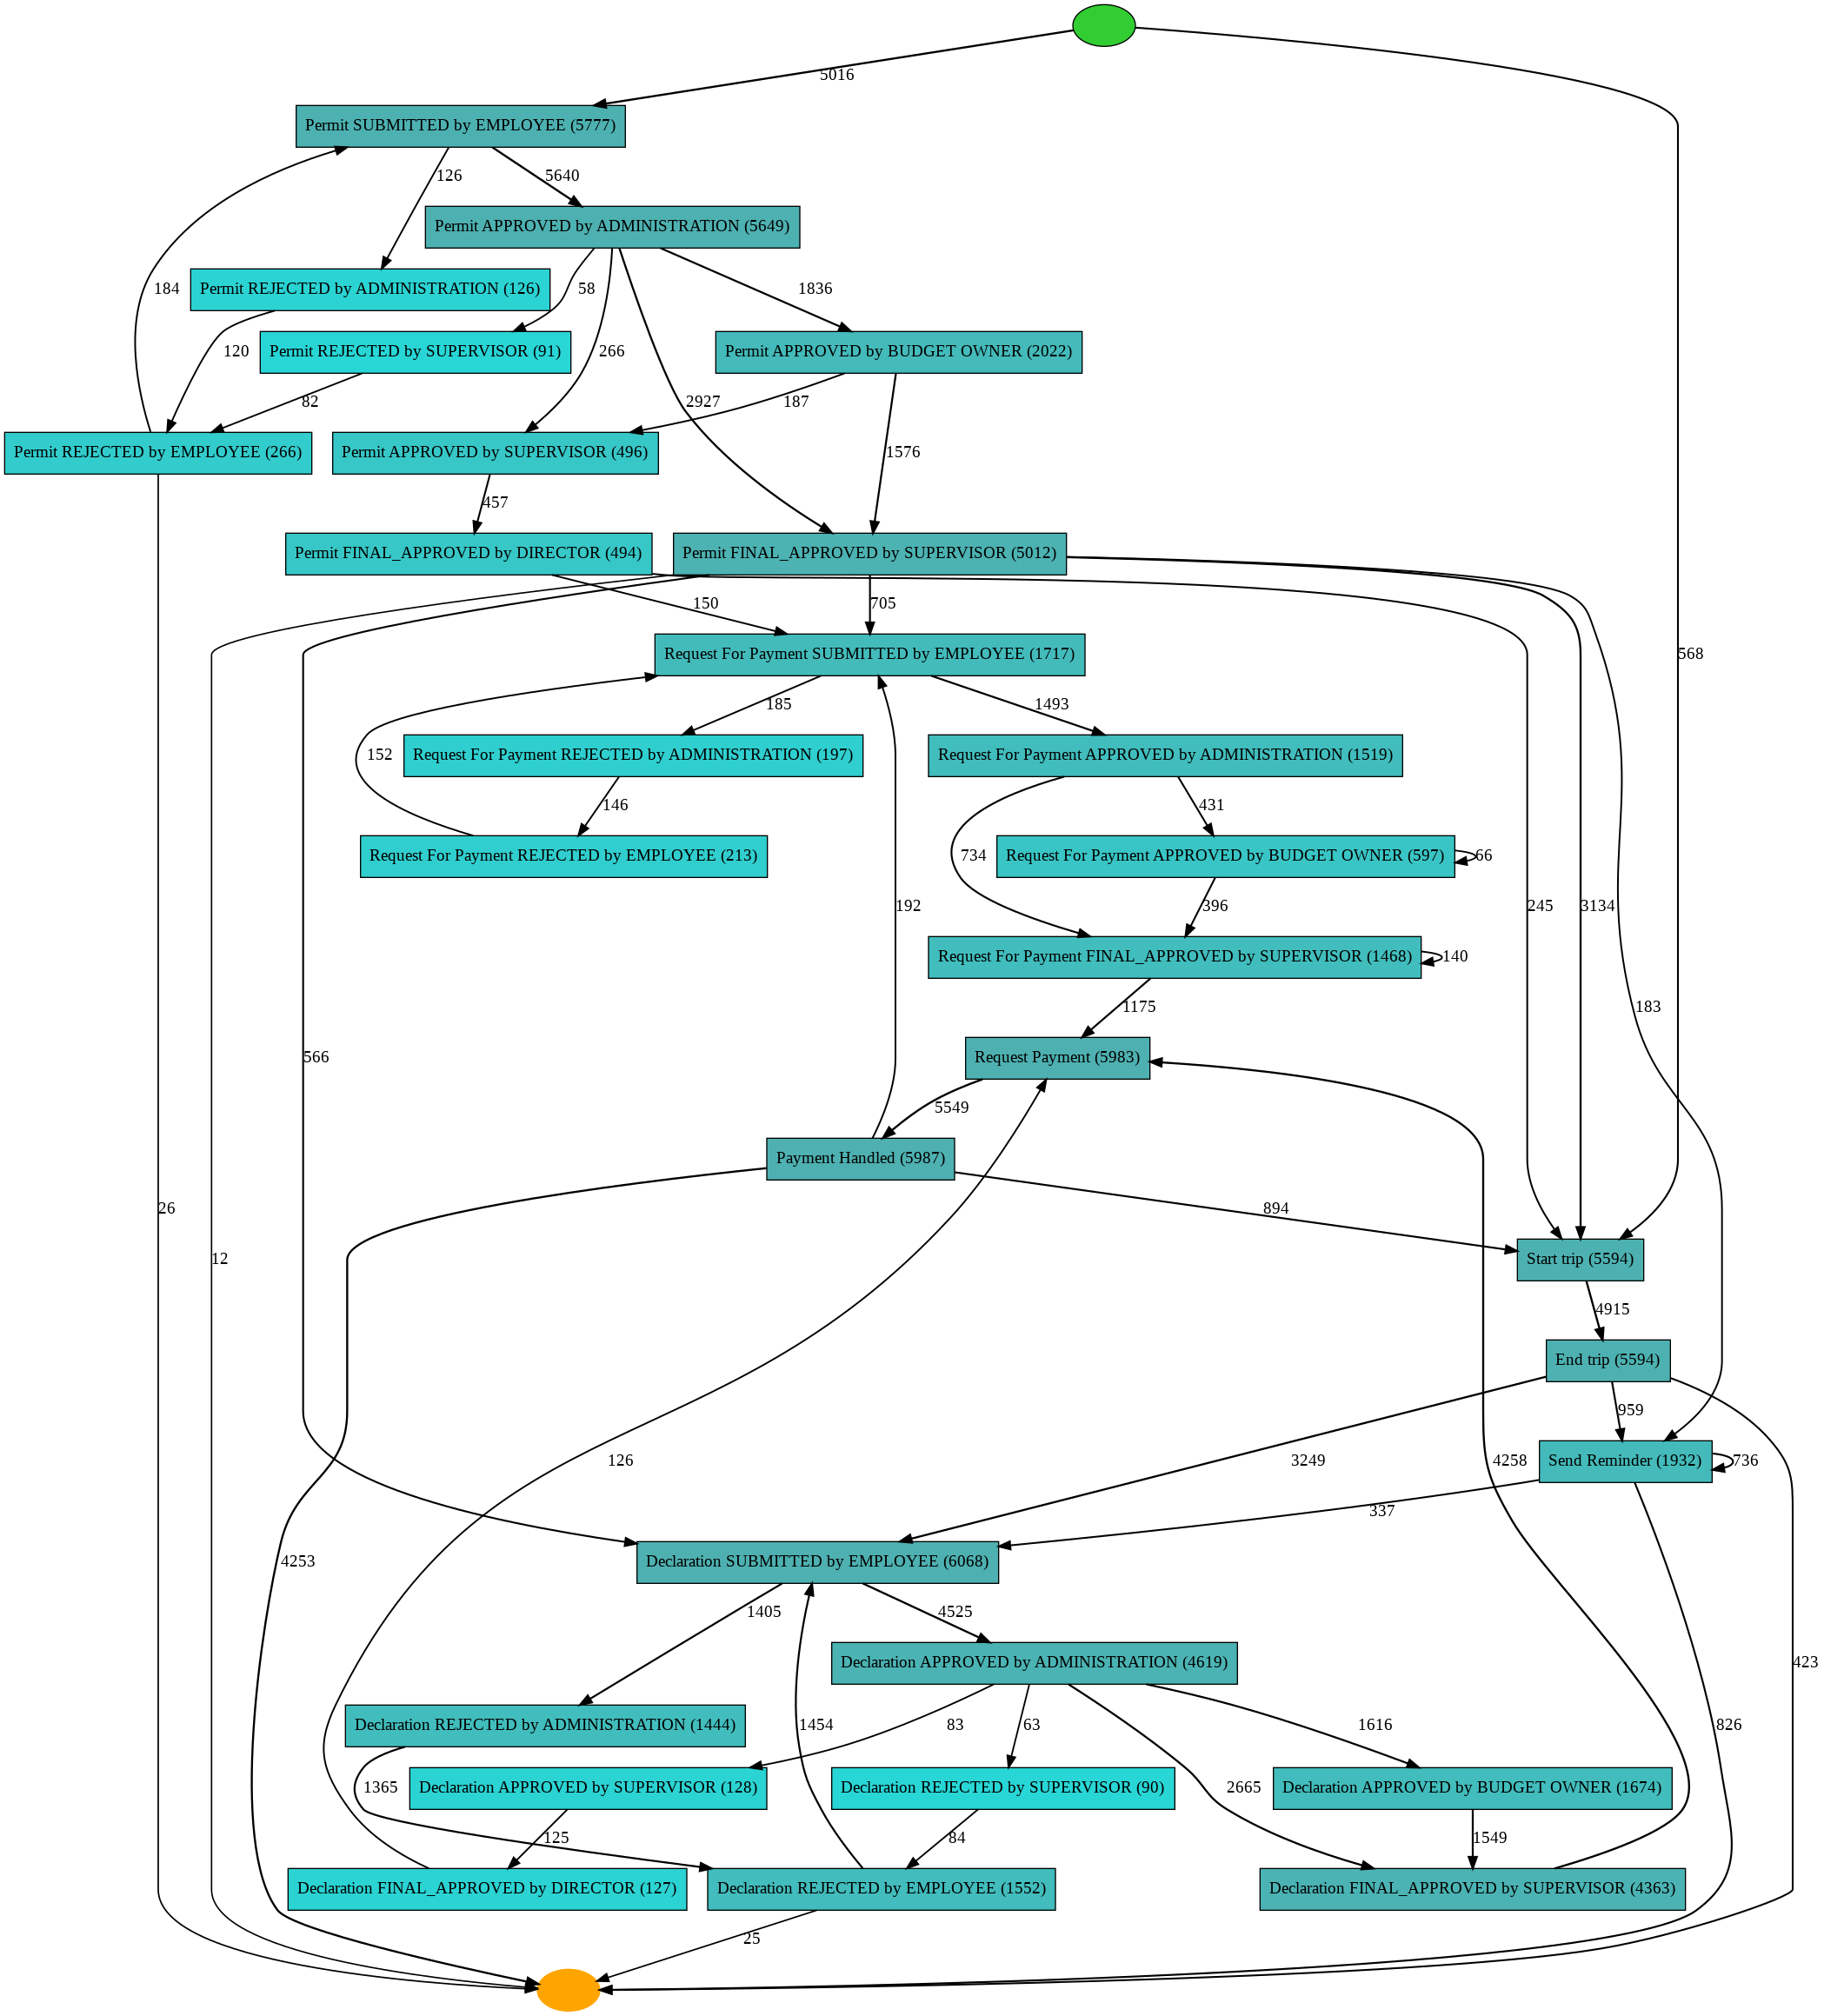

-----------------------------------------------
-------------------Inductive Miner-------------


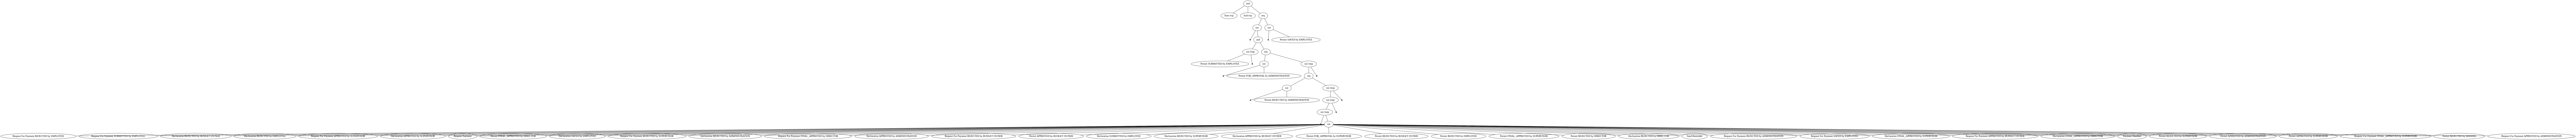

replaying log with TBR, completed variants ::   0%|          | 0/1114 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9861 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1114 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0} Precision:  0.07954952115458813 Generalization:  0.8381847258050701 Simplicity:  0.4806629834254144
| Miner     |   Fitness |   Precision |   Generalization |   Simplicity |
|-----------+-----------+-------------+------------------+--------------|
| Alpha     |  0.44587  |   0         |         0.826658 |     0.585586 |
| Heuristic |  0.965153 |   0.921644  |         0.909456 |     0.620915 |
| Inductive |  1        |   0.0795495 |         0.838185 |     0.480663 |


In [15]:
net, im, fm = discovery_visualize_evaluate(permitLog, visualize = False)

-----------------------------------------------
-------------------Dfg visualization-----------
-----------------------------------------------
-------------------Alpha Miner-----------------


replaying log with TBR, completed variants ::   0%|          | 0/57 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/188 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/57 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.6835116210762482, 'log_fitness': 0.6854308410493368, 'percentage_of_fitting_traces': 0.0} Precision:  0.0 Generalization:  0.7195656261975618 Simplicity:  0.4461538461538462
-----------------------------------------------
-------------------Heuristic Miner-------------


replaying log with TBR, completed variants ::   0%|          | 0/57 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/188 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/57 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 97.66144990106135, 'average_trace_fitness': 0.9973419006745012, 'log_fitness': 0.9969055340073335, 'percentage_of_fitting_traces': 97.66144990106135} Precision:  0.9917959021368327 Generalization:  0.7914044778080311 Simplicity:  0.6888888888888889


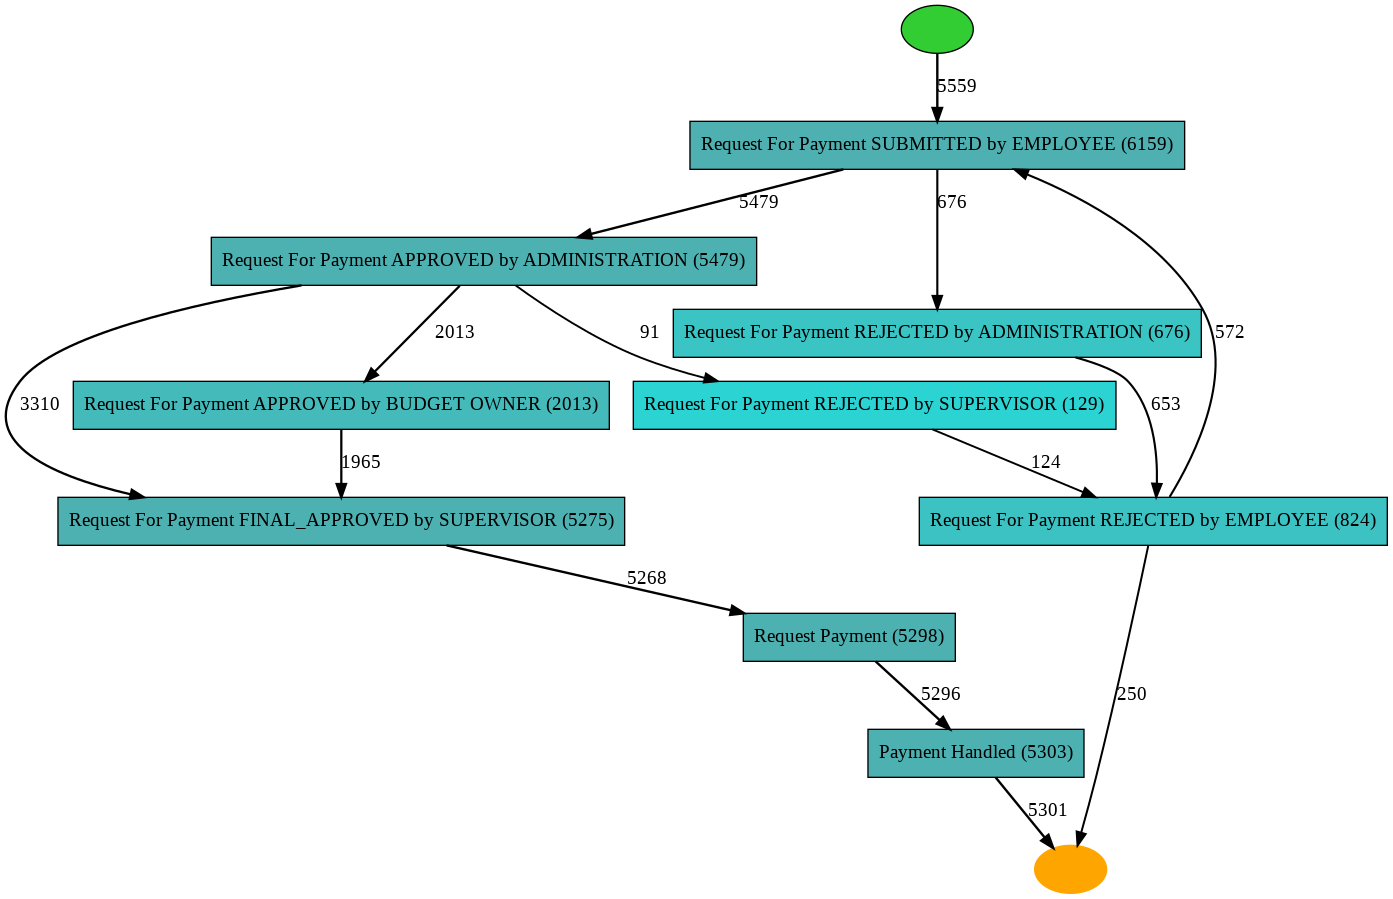

-----------------------------------------------
-------------------Inductive Miner-------------


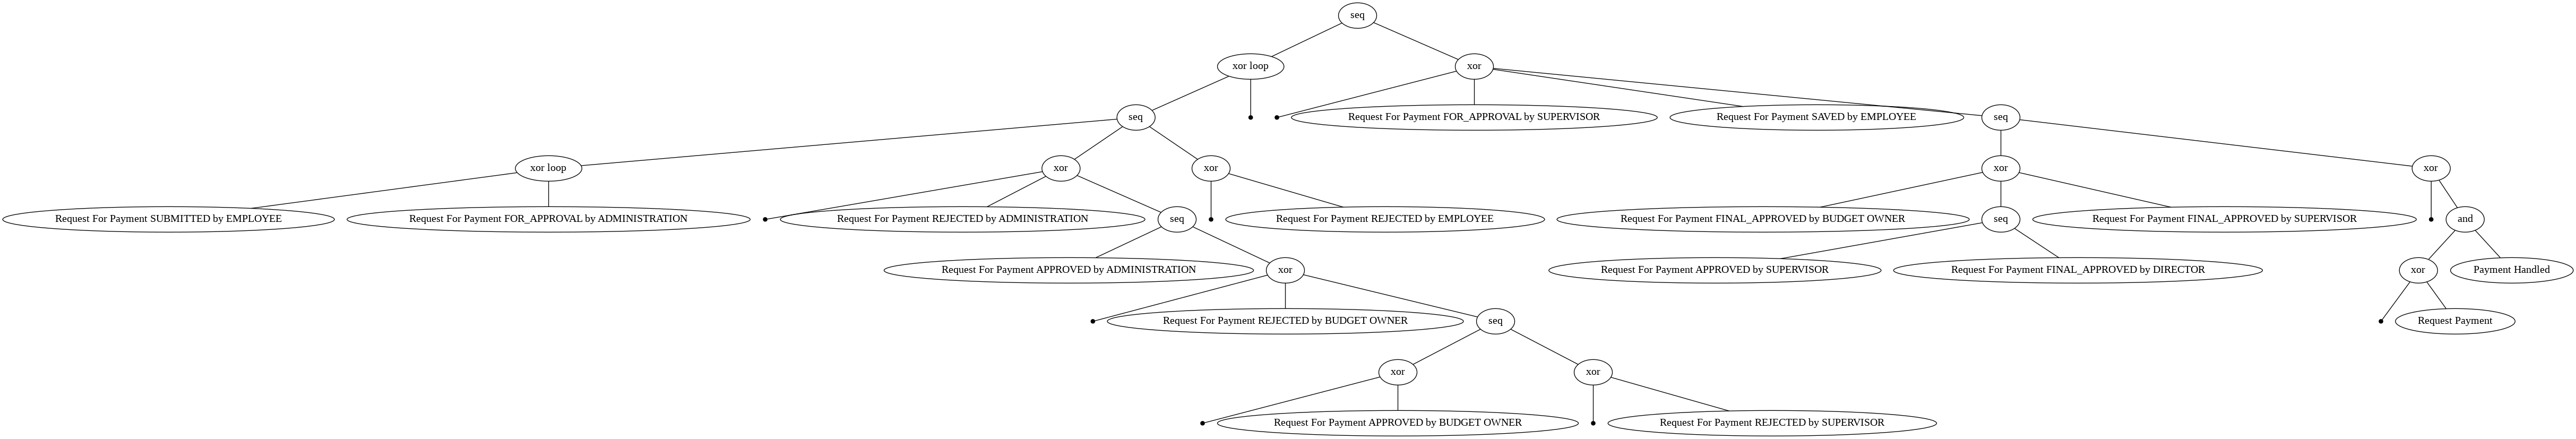

replaying log with TBR, completed variants ::   0%|          | 0/57 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/188 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/57 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0} Precision:  0.4517199370672609 Generalization:  0.7789196393636212 Simplicity:  0.6000000000000001
| Miner     |   Fitness |   Precision |   Generalization |   Simplicity |
|-----------+-----------+-------------+------------------+--------------|
| Alpha     |  0.683512 |    0        |         0.719566 |     0.446154 |
| Heuristic |  0.997342 |    0.991796 |         0.791404 |     0.688889 |
| Inductive |  1        |    0.45172  |         0.77892  |     0.6      |


In [16]:
net, im, fm = discovery_visualize_evaluate(requestForPayment, visualize = False)

-----------------------------------------------
-------------------Dfg visualization-----------
-----------------------------------------------
-------------------Alpha Miner-----------------


replaying log with TBR, completed variants ::   0%|          | 0/148 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/707 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/148 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.6377143839751651, 'log_fitness': 0.6419992275733634, 'percentage_of_fitting_traces': 0.0} Precision:  0.0 Generalization:  0.8878005345940316 Simplicity:  0.12550607287449395
-----------------------------------------------
-------------------Heuristic Miner-------------


replaying log with TBR, completed variants ::   0%|          | 0/148 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/707 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/148 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 31.74061433447099, 'average_trace_fitness': 0.9668622487793832, 'log_fitness': 0.9650468138967272, 'percentage_of_fitting_traces': 31.74061433447099} Precision:  0.5524798753570501 Generalization:  0.8676517087351212 Simplicity:  0.6764705882352942


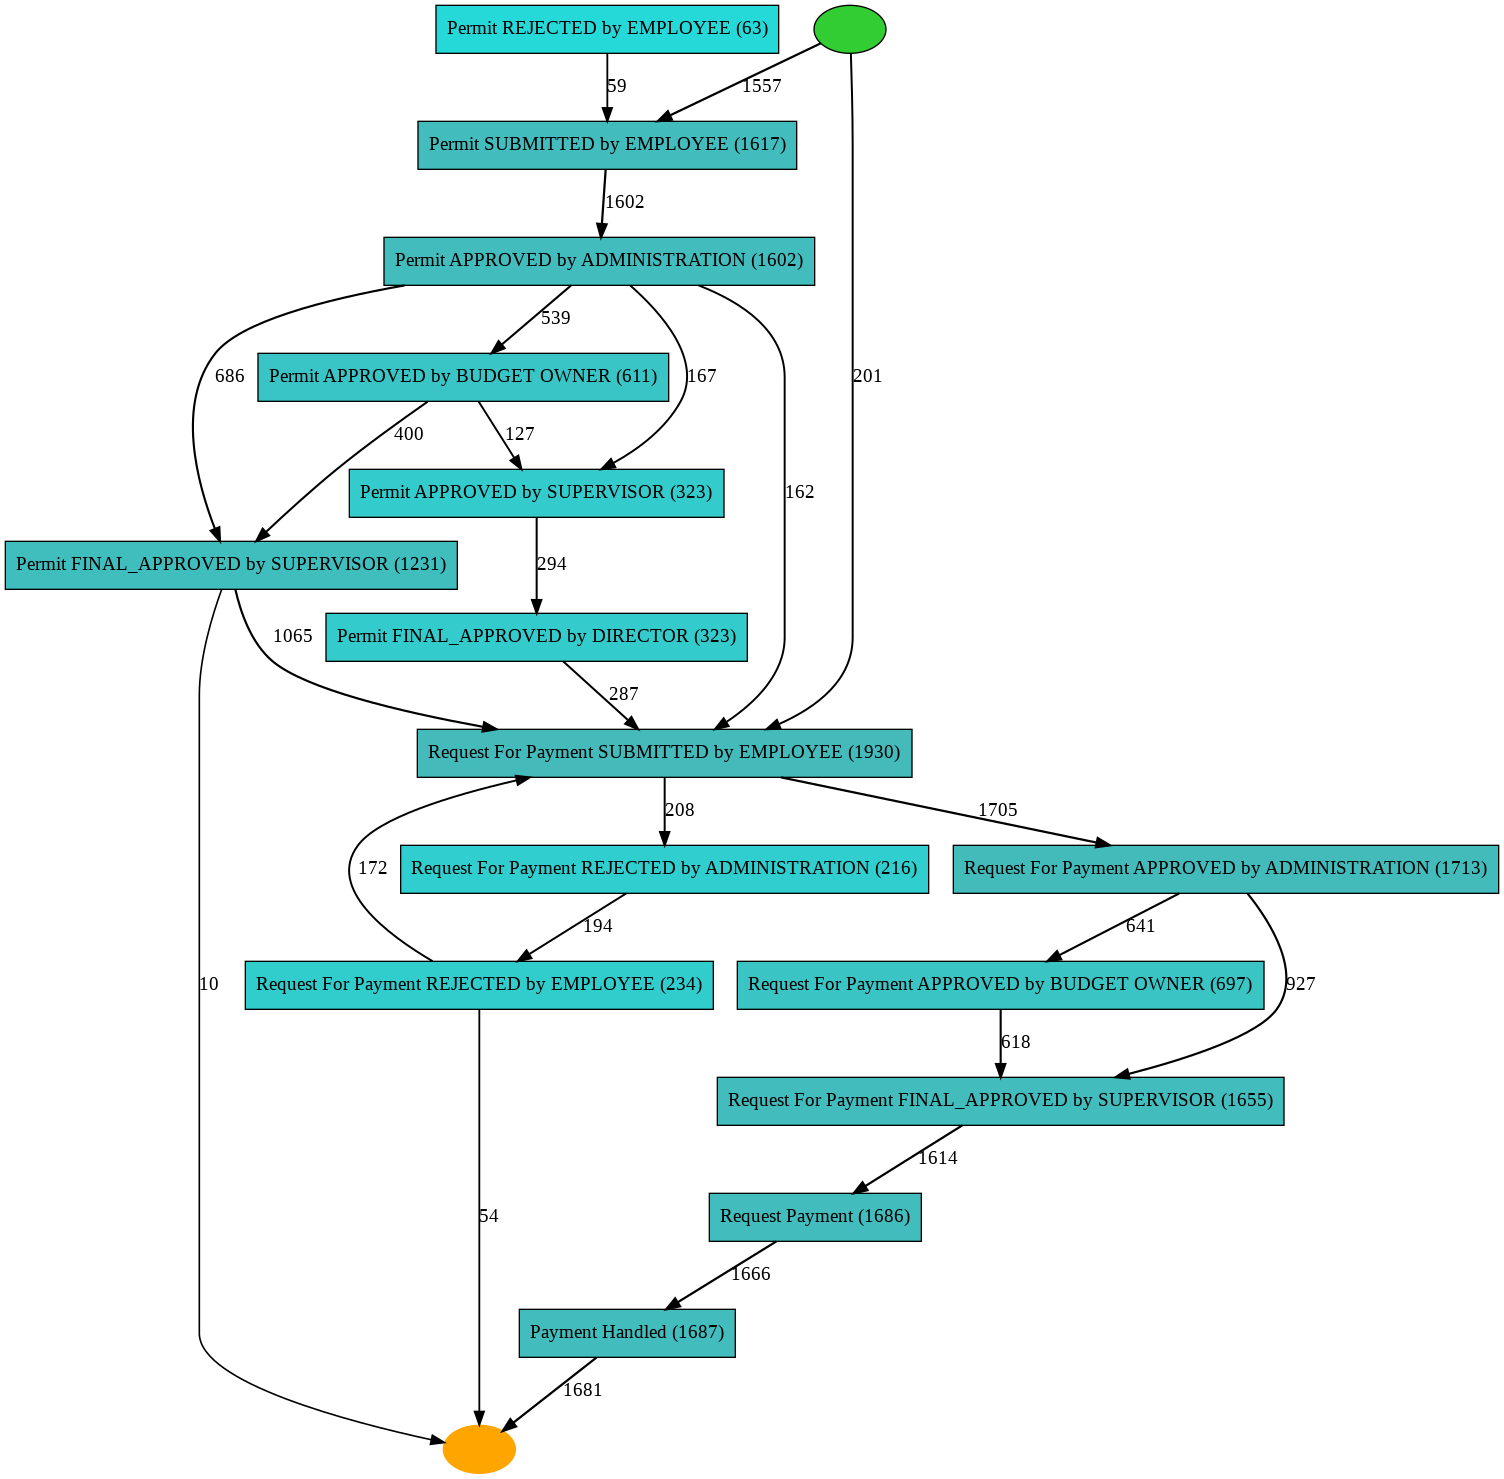

-----------------------------------------------
-------------------Inductive Miner-------------


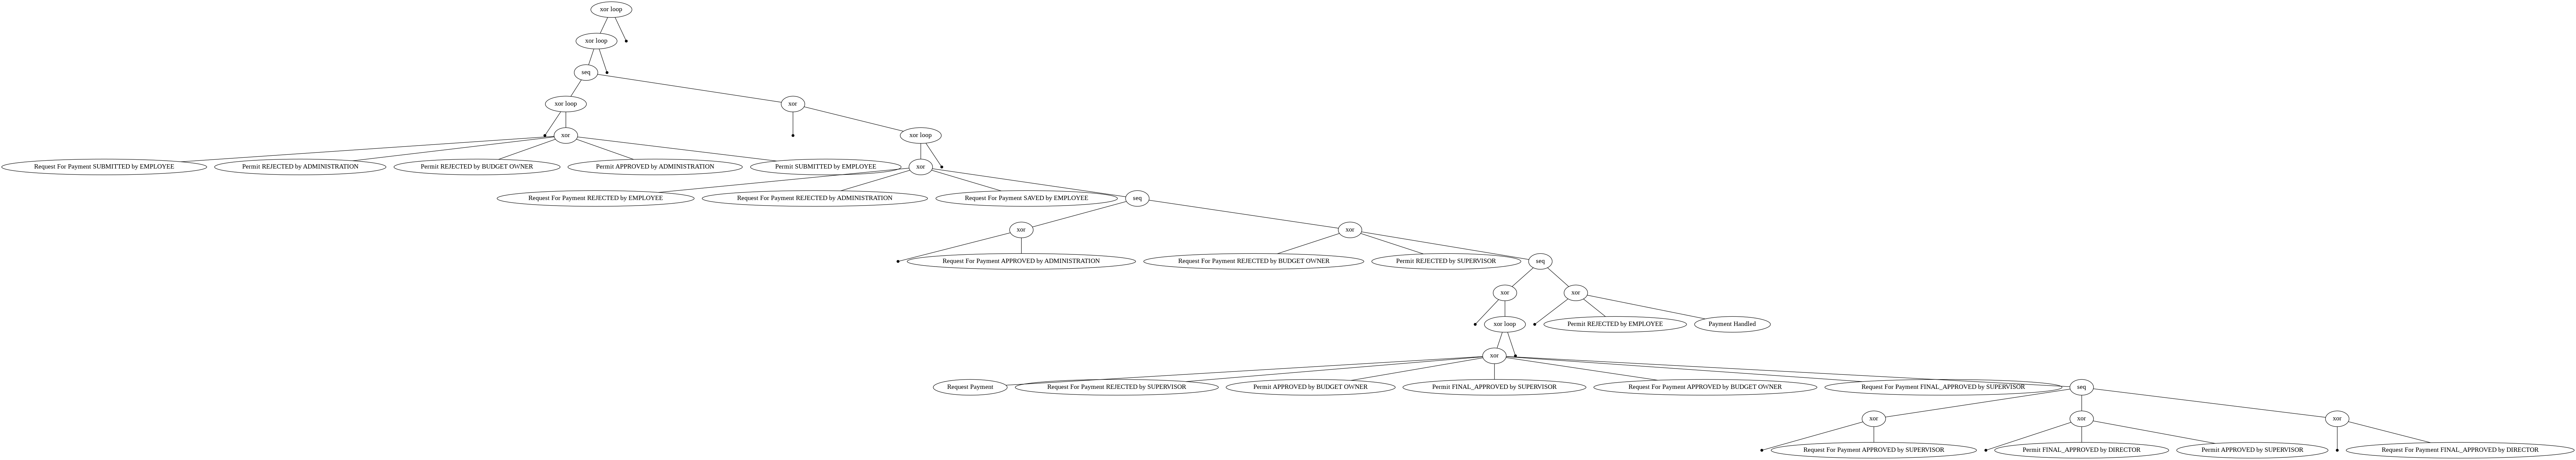

replaying log with TBR, completed variants ::   0%|          | 0/148 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/707 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/148 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0} Precision:  0.11128834186524639 Generalization:  0.8836803771517571 Simplicity:  0.5333333333333333
| Miner     |   Fitness |   Precision |   Generalization |   Simplicity |
|-----------+-----------+-------------+------------------+--------------|
| Alpha     |  0.637714 |    0        |         0.887801 |     0.125506 |
| Heuristic |  0.966862 |    0.55248  |         0.867652 |     0.676471 |
| Inductive |  1        |    0.111288 |         0.88368  |     0.533333 |


In [17]:
net, im, fm = discovery_visualize_evaluate(prepaidTravelCost, visualize = False)

**Conformance Checking**


Using the net discovered by the heuristic miner

In [55]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.algo.conformance.tokenreplay import algorithm as token_based_replay
from pm4py.algo.conformance.tokenreplay.diagnostics import duration_diagnostics
from pm4py.algo.conformance.tokenreplay.diagnostics import duration_diagnostics
from pm4py.algo.conformance.tokenreplay.diagnostics import root_cause_analysis

def conformance_ck_replay(event_log, net, im, fm):
  replayed_traces = token_replay.apply(event_log, net, im, fm)
  print("REPLAY")
  print("Number of traces", len(replayed_traces))

  anomalous_traces = []
  i = 0
  while i < len(replayed_traces):
    if replayed_traces[i]["trace_fitness"] < 1:
      anomalous_traces.append(event_log[i].attributes["concept:name"])
    i += 1
  # print the list as a string
  #print(', '.join(map(str, anomalous_traces)))
  print("Number of anomalous traces ", len(anomalous_traces))

  print("Percentage of anomalous traces", (len(anomalous_traces)/len(replayed_traces))*100 , '%')

  anomalous_traces_type = {}
  anomalous_traces_type_keys = []


  i = 0
  while i < len(replayed_traces):
    if replayed_traces[i]["transitions_with_problems"]: # Empty lists are considered False in Python
      key = i
      anomalous_traces_type[key] = replayed_traces[i]["transitions_with_problems"][0]
      anomalous_traces_type_keys.append(key)
      #print(replayed_traces[i]["transitions_with_problems"][0])
    i += 1
  #print(anomalous_traces_type)

  # store the names (the keys of the new dict) as a set (keeps elements unique)
  att = set(anomalous_traces_type.values())

  # use a list comprehension, iterating through keys and checking the values match each n
  anomalous_traces_type_groups = {}
  for n in att:
      anomalous_traces_type_groups[n] = [k for k in anomalous_traces_type.keys() if anomalous_traces_type[k] == n]
  print(anomalous_traces_type_groups)


def comformance_ck_diagnostic(log, net, im, fm):
  # from pm4py documentation
  parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: True,
                    token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True}
  replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(log, 
                                                                                                net,
                                                                                                im,
                                                                                                fm,
                                                                                                parameters=parameters_tbr)
  print('Throughput analysis (unfit execution)')
  trans_diagnostics = duration_diagnostics.diagnose_from_trans_fitness(log, trans_fitness)
  for trans in trans_diagnostics:
      print(trans, trans_diagnostics[trans])
  
  print('Throughput analysis (activities)')
  act_diagnostics = duration_diagnostics.diagnose_from_notexisting_activities(log, unwanted_activities)
  for act in act_diagnostics:
      print(act, act_diagnostics[act])

In [56]:
conformance_ck_replay(domesticDeclarations, dom_net, dom_im, dom_fm)
comformance_ck_diagnostic(domesticDeclarations, dom_net, dom_im, dom_fm)

replaying log with TBR, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

REPLAY
Number of traces 8061
Number of anomalous traces  54
Percentage of anomalous traces 0.6698920729438035 %
{(Declaration REJECTED by SUPERVISOR, 'Declaration REJECTED by SUPERVISOR'): [308, 653, 806, 813, 953, 1013, 1118, 1347, 1661, 2210, 2286, 3443, 3742, 3753, 3887, 3888, 5039, 5422, 5480, 5525, 5526, 5527, 5568, 5702, 5752, 5816, 6167, 6168, 6669, 6830, 7714, 7984], (Declaration SUBMITTED by EMPLOYEE, 'Declaration SUBMITTED by EMPLOYEE'): [607, 1575, 2089, 2101, 2717, 2912, 3133, 3785, 4436, 4441, 4542, 5007, 5458, 5988, 6901, 7312], (Payment Handled, 'Payment Handled'): [2479, 7572, 7695, 7861, 7870, 7901]}


replaying log with TBR, completed variants ::   0%|          | 0/8061 [00:00<?, ?it/s]

Throughput analysis (unfit execution)
(Declaration SUBMITTED by EMPLOYEE, 'Declaration SUBMITTED by EMPLOYEE') {'n_fit': 8045, 'n_underfed': 16, 'fit_median_time': 693861.0, 'underfed_median_time': 1316263.5, 'relative_throughput': 1.8970132346392146}
(Payment Handled, 'Payment Handled') {'n_fit': 7896, 'n_underfed': 7, 'fit_median_time': 694744.5, 'underfed_median_time': 4681756.0, 'relative_throughput': 6.73881693198003}
(Declaration REJECTED by SUPERVISOR, 'Declaration REJECTED by SUPERVISOR') {'n_fit': 181, 'n_underfed': 32, 'fit_median_time': 1218186.0, 'underfed_median_time': 1824007.0, 'relative_throughput': 1.4973140390712092}
Throughput analysis (activities)
Declaration FOR_APPROVAL by ADMINISTRATION {'n_containing': 1, 'n_fit': 8060, 'fit_median_time': 694051.0, 'containing_median_time': 2921422.0, 'relative_throughput': 4.209232462744092}


In [57]:
conformance_ck_replay(internationalDeclarations, int_net, int_im, int_fm)
comformance_ck_diagnostic(internationalDeclarations, int_net, int_im, int_fm)

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

REPLAY
Number of traces 4951
Number of anomalous traces  1855
Percentage of anomalous traces 37.46717834780852 %
{(Permit REJECTED by EMPLOYEE, 'Permit REJECTED by EMPLOYEE'): [798, 984, 1301, 1396, 1578, 1663, 1669, 1686, 2864, 2947, 3077, 3162, 3184, 3266, 3396, 3532, 3641, 3922, 4193, 4289, 4764, 4842], (Permit SUBMITTED by EMPLOYEE, 'Permit SUBMITTED by EMPLOYEE'): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 70, 71, 72, 77, 78, 131, 132, 133, 164, 191, 192, 240, 241, 242, 248, 249, 250, 251, 252, 295, 296, 297, 298, 299, 325, 326, 358, 359, 385, 398, 399, 403, 404, 405, 406, 407, 440, 441, 442, 483, 519, 540, 541, 552, 553, 554, 555, 556, 557, 607, 608, 609, 636, 669, 670, 691, 692, 696, 697, 698, 699, 700, 701, 735, 736, 737, 738, 739, 740, 741, 807, 828, 858, 859, 860, 869, 878, 935, 938, 945

replaying log with TBR, completed variants ::   0%|          | 0/4951 [00:00<?, ?it/s]

Throughput analysis (unfit execution)
(Permit APPROVED by SUPERVISOR, 'Permit APPROVED by SUPERVISOR') {'n_fit': 5, 'n_underfed': 441, 'fit_median_time': 8742023.0, 'underfed_median_time': 8395978.0, 'relative_throughput': 0.9604159128842374}
(Start trip, 'Start trip') {'n_fit': 4210, 'n_underfed': 741, 'fit_median_time': 5722282.5, 'underfed_median_time': 4351758.0, 'relative_throughput': 0.7604933870356803}
(Declaration SUBMITTED by EMPLOYEE, 'Declaration SUBMITTED by EMPLOYEE') {'n_fit': 4761, 'n_underfed': 133, 'fit_median_time': 5464884.0, 'underfed_median_time': 7236022.0, 'relative_throughput': 1.324094344911987}
(Declaration APPROVED by SUPERVISOR, 'Declaration APPROVED by SUPERVISOR') {'n_fit': 3, 'n_underfed': 143, 'fit_median_time': 7267665.0, 'underfed_median_time': 6848773.0, 'relative_throughput': 0.9423622305100744}
(Send Reminder, 'Send Reminder') {'n_fit': 369, 'n_underfed': 11, 'fit_median_time': 7835458.0, 'underfed_median_time': 18076058.0, 'relative_throughput': 2.

In [66]:
from pm4py.algo.conformance.alignments.decomposed import algorithm as decomp_alignments
from pm4py.algo.evaluation.replay_fitness import algorithm as rp_fitness_evaluator

def conformance_ck_alignment(event_log, net, im, fm):
  # Alignment-based replay aims to find one of the best alignment between the trace and the model.
  aligned_traces = alignments.apply_log(event_log, net, im, fm)

  print("ALIGNMENTS")
  print("Number of traces", len(aligned_traces))

  anomalous_traces = []
  regular_traces = []
  i = 0
  while i < len(aligned_traces):
    if aligned_traces[i]["fitness"] != 1:
      #anomalous_traces.append(event_log[i].attributes["concept:name"])
      anomalous_traces.append(aligned_traces[i]['alignment'])
    else:
      regular_traces.append(aligned_traces[i]['alignment'])
    i += 1
  # print the list as a string
  #print(', '.join(map(str, anomalous_traces)))
  #print(anomalous_traces)
  print("Number of anomalous traces ", len(anomalous_traces))

  print("Percentage of anomalous traces", (len(anomalous_traces)/len(aligned_traces))*100 , '%')

  # Generate a Dataframe of the regular traces
  regular_traces_df = pd.DataFrame(regular_traces)


  # Generate the Consensus Sequence: The consensus sequence captures the major activity in each column and can be considered as a back-bone sequence for the process.
  # For each column print the mode value, its absolute occurence, its relative occurence 
  alignments_mode_count = pd.DataFrame({'Columns': regular_traces_df.columns,
                      'Mode':[regular_traces_df[x].mode()[0] for x in regular_traces_df],
                    'Mode freq.':[regular_traces_df[x].isin(regular_traces_df[x].mode()).sum() for x in regular_traces_df],
                    'Mode freq. %':[(regular_traces_df[x].isin(regular_traces_df[x].mode()).sum())/(len(aligned_traces))*100 for x in regular_traces_df]
                    })
  print(alignments_mode_count)

  # Print the consenus sequence only 
  #consensus_sequence = alignments_mode_count['Mode'].tolist()
  #print(consensus_sequence)

  # Visualize the share of each activity in the consensus sequence
  fig, axes = plt.subplots(figsize=(7,5), dpi=100)
  plt.bar(alignments_mode_count['Columns'], height=alignments_mode_count['Mode freq. %'])
  plt.title('Share of each activity in the consensus sequence')

def conformance_ck_alignment_pm(log, net, im, fm):
  # Decomposition of Alignments
  conf = decomp_alignments.apply(log, net, im, fm, 
                                 parameters={decomp_alignments.Variants.RECOMPOS_MAXIMAL.value.Parameters.PARAM_THRESHOLD_BORDER_AGREEMENT: 2})
  fitness = rp_fitness_evaluator.evaluate(conf, variant=rp_fitness_evaluator.Variants.ALIGNMENT_BASED)
  print(fitness)


In [67]:
conformance_ck_alignment_pm(domesticDeclarations, dom_net, dom_im, dom_fm)

aligning log with decomposition/recomposition, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

{'percFitTraces': 99.33010792705619, 'averageFitness': 0.9992900496453754, 'percentage_of_fitting_traces': 99.33010792705619, 'average_trace_fitness': 0.9992900496453754, 'log_fitness': 0.9989927683288236}


aligning log, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

ALIGNMENTS
Number of traces 8061
Number of anomalous traces  54
Percentage of anomalous traces 0.6698920729438035 %
    Columns                                               Mode  Mode freq.  \
0         0                                         (>>, None)        8007   
1         1  (Declaration SUBMITTED by EMPLOYEE, Declaratio...        8007   
2         2  (Declaration APPROVED by ADMINISTRATION, Decla...        7288   
3         3                                         (>>, None)        5329   
4         4  (Declaration FINAL_APPROVED by SUPERVISOR, Dec...        7082   
5         5                 (Request Payment, Request Payment)        7082   
6         6                 (Payment Handled, Payment Handled)        7082   
7         7  (Declaration APPROVED by ADMINISTRATION, Decla...         583   
8         8                                         (>>, None)         441   
9         9  (Declaration FINAL_APPROVED by SUPERVISOR, Dec...         564   
10       10               

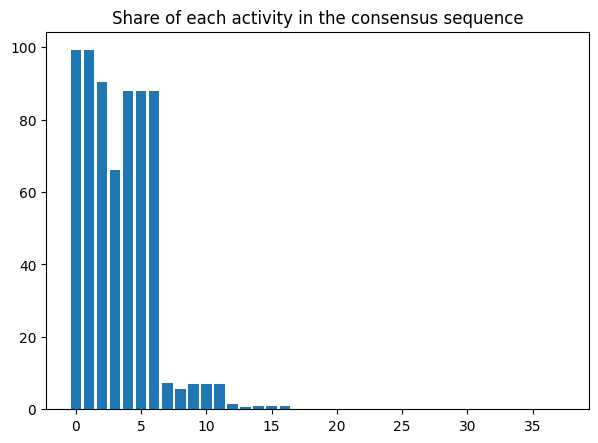

In [68]:
conformance_ck_alignment(domesticDeclarations, dom_net, dom_im, dom_fm)

In [69]:
conformance_ck_alignment_pm(internationalDeclarations, int_net, int_im, int_fm)

aligning log with decomposition/recomposition, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

{'percFitTraces': 65.38305634373734, 'averageFitness': 0.947609741069094, 'percentage_of_fitting_traces': 65.38305634373734, 'average_trace_fitness': 0.947609741069094, 'log_fitness': 0.9495211878723215}


aligning log, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

ALIGNMENTS
Number of traces 4951
Number of anomalous traces  1898
Percentage of anomalous traces 38.33568975964452 %
    Columns                                               Mode  Mode freq.  \
0         0                                         (>>, None)        3053   
1         1  (Permit SUBMITTED by EMPLOYEE, Permit SUBMITTE...        3024   
2         2  (Permit APPROVED by ADMINISTRATION, Permit APP...        3000   
3         3                                         (>>, None)        2035   
4         4  (Permit FINAL_APPROVED by SUPERVISOR, Permit F...        2006   
5         5                                         (>>, None)        2006   
6         6                           (Start trip, Start trip)        2006   
7         7                               (End trip, End trip)        2006   
8         8                                         (>>, None)        2021   
9         9  (Declaration SUBMITTED by EMPLOYEE, Declaratio...        1878   
10       10  (Declaration

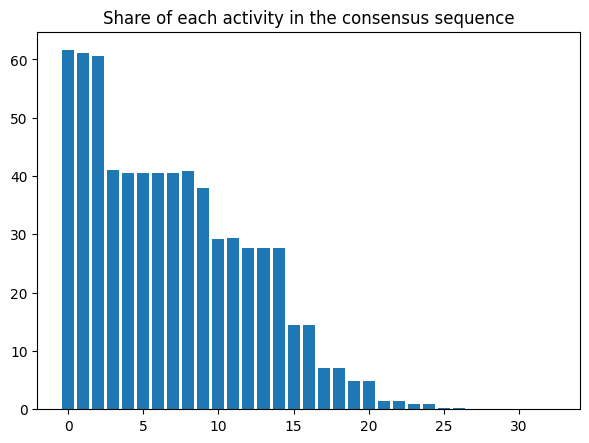

In [70]:
conformance_ck_alignment(internationalDeclarations, int_net, int_im, int_fm)